### 1. Load a picture
（Taking the astronaut in skimage library as an example）

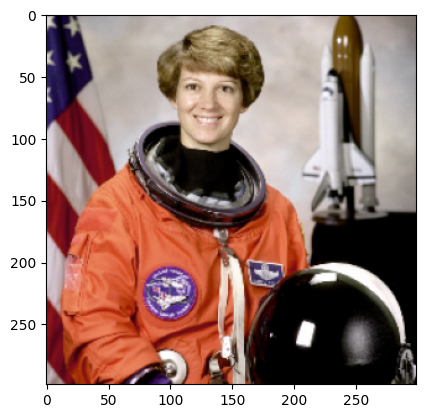

In [59]:
from skimage.data import astronaut
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

img = img_as_float(astronaut()[::2, ::2])
img = resize(img, (299, 299))
img = np.array([img])

plt.imshow(img[0])
plt.show()

### 2. Get the predict

In [60]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

inet_model = inc_net.InceptionV3()
preds = inet_model.predict(img)
for x in decode_predictions(preds)[0]:
    print(x)


('n03379051', 'football_helmet', 0.5395003)
('n03127747', 'crash_helmet', 0.08094214)
('n02790996', 'barbell', 0.0383344)
('n02860847', 'bobsled', 0.030651012)
('n04192698', 'shield', 0.029816164)


We now have gotten 5 explainations.  The first two are both understood for there is a helmet in the picture indeed.  But we cannot find the relationship with the third predict and picture.  LIME is prepared for this.

### 3. Apply LIME 

In [61]:
import lime
from lime import lime_image
explainer = lime_image.LimeImageExplainer()
x=img[0].astype(np.double)
explanation = explainer.explain_instance(x, inet_model.predict, top_labels=5, hide_color=0, num_samples=500)

100%|██████████| 500/500 [00:32<00:00, 15.18it/s]


The following picture expains barbell.


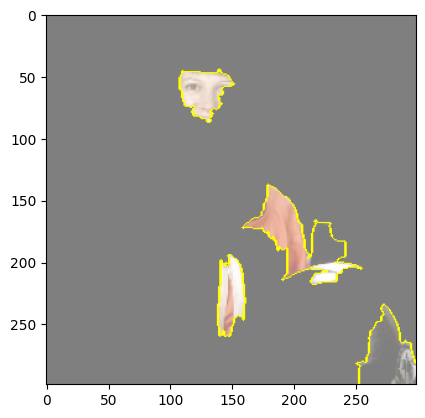

In [62]:
from skimage.segmentation import mark_boundaries
index = 2
print(f'The following picture expains {decode_predictions(preds)[0][index][1]}.')
temp, mask = explanation.get_image_and_mask(explanation.top_labels[index], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))